In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils



import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
from numpy import arange
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import seaborn as sns

## Hyperparameters

In [2]:
epochs = 20
batch_size = 1

## Loading data

In [26]:
train_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_train.csv'
test_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_valid.csv'
train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [27]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


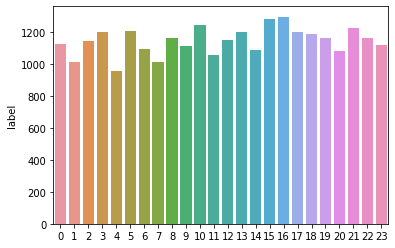

In [29]:
sns.barplot(x=train_data.label.value_counts().index, y=train_data.label.value_counts())
plt.show()

The number of data in classes are pretty balanced on the training set.

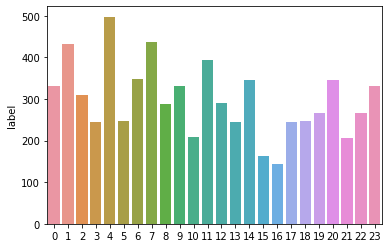

In [30]:
sns.barplot(x=test_data.label.value_counts().index, y=test_data.label.value_counts())
plt.show()

In [7]:
unq_classes = set(list(train_data['label'])+list(test_data['label']))
n_classes = len(unq_classes)
print('number of classes: ', n_classes)
print('classes: ', unq_classes)

number of classes:  24
classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


## Preparing data

In [8]:
y_train = train_data['label']
y_val = test_data['label']
del train_data['label']
del test_data['label']

X_train = train_data.values.reshape(-1,1,28,28)
X_val = test_data.values.reshape(-1,1,28,28)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_test shape: {X_val.shape}. y_test shape: {y_val.shape}')

X_train shape: (27455, 1, 28, 28). y_train shape: (27455,)
X_test shape: (7172, 1, 28, 28). y_test shape: (7172,)


In [9]:
# _y_train = train_data['label']
# y_test = test_data['label']
# del train_data['label']
# del test_data['label']

# _X_train = train_data.values.reshape(-1,1,28,28)
# X_test = test_data.values.reshape(-1,1,28,28)


### Spliting data

In [10]:
# _X_train[0].shape
# _y_train[0].shape

In [11]:
# Spliting the training data into two sets for training and validation
# X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.2, random_state=42)

# print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
# print(f'X_val shape: {X_val.shape}. y_val shape: {y_val.shape}')
# print(f'X_test shape: {X_test.shape}. y_test shape: {y_test.shape}')

### Showing some image and label examples

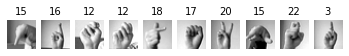

In [12]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[15:25], y_train[15:25])

### Normalize the data


In [13]:
# Exploring min and max values of image pixels
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')

X_train: min= 0, max=255


In [14]:
# Normalize images by dividing pixel values by the max
X_train = X_train/255
X_val = X_val/255
# X_test = X_test/255

print(f'X_train: min= {X_train.min()}, max={X_train.max()}')
print(f'X_val: min= {X_val.min()}, max={X_val.max()}')
# print(f'X_test: min= {X_test.min()}, max={X_test.max()}')

X_train: min= 0.0, max=1.0
X_val: min= 0.0, max=1.0


In [15]:
# Exploring the class labels to consider encoding them if neccessary
n_classes

24

### Loading data to Dataset and Dataloader object

In [16]:
class CustomDataset():
    def __init__(self, X, Y) -> None:
        super().__init__()
        self.X = X
        self.Y = Y.tolist()
        # print(type(self.X), type(self.Y))


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        self.x_tensor = torch.tensor(x, dtype = torch.float) #float32
        self.y_tensor = torch.tensor(y, dtype = torch.int64)
        return self.x_tensor, self.y_tensor

# passing data to the customized dataset class we created
train_datatensor = CustomDataset(X_train, y_train)
val_datatensor = CustomDataset(X_val, y_val)
# test_datatensor = CustomDataset(X_test, y_test)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )
# test_dataloader = DataLoader(test_datatensor, sampler = torch.utils.data.SequentialSampler(test_datatensor), batch_size=batch_size )



In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


## Creating model

In [18]:
class Net(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.softmax(self.fc3(x))
        return self.softmax(x)

model= Net(n_classes = n_classes)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


## Training model

In [19]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [20]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total_batches = 0
    correct_batches = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            # print('labels.size(0)', labels.size(0))
            total_batches+= 1 #labels.size(0)
            correct_batches+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct_batches / total_batches, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './asl.pth'
    if val_loss < best_loss:
        torch.save(model.state_dict(), checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




  4%|▍         | 1053/27455 [00:03<01:32, 285.45it/s]

Step [1000/27455]: Loss = 3.173776149749756, Accuracy = 0.0


  7%|▋         | 2046/27455 [00:07<01:35, 266.75it/s]

Step [2000/27455]: Loss = 3.1791412830352783, Accuracy = 0.0


 11%|█         | 3050/27455 [00:10<01:28, 277.07it/s]

Step [3000/27455]: Loss = 3.1775779724121094, Accuracy = 0.0


 15%|█▍        | 4058/27455 [00:14<01:24, 276.96it/s]

Step [4000/27455]: Loss = 3.176076650619507, Accuracy = 0.0


 18%|█▊        | 5053/27455 [00:18<01:24, 265.72it/s]

Step [5000/27455]: Loss = 3.1803274154663086, Accuracy = 0.0


 22%|██▏       | 6040/27455 [00:22<01:26, 246.38it/s]

Step [6000/27455]: Loss = 3.181236982345581, Accuracy = 0.0


 26%|██▌       | 7040/27455 [00:26<01:34, 216.28it/s]

Step [7000/27455]: Loss = 3.181469440460205, Accuracy = 0.0


 29%|██▉       | 8035/27455 [00:30<01:25, 228.29it/s]

Step [8000/27455]: Loss = 3.181596040725708, Accuracy = 0.0


 33%|███▎      | 9043/27455 [00:34<01:18, 235.49it/s]

Step [9000/27455]: Loss = 3.1560840606689453, Accuracy = 1.0


 36%|███▋      | 10021/27455 [00:38<01:14, 234.75it/s]

Step [10000/27455]: Loss = 3.156763792037964, Accuracy = 1.0


 40%|████      | 11037/27455 [00:43<01:07, 243.82it/s]

Step [11000/27455]: Loss = 3.16256046295166, Accuracy = 0.0


 44%|████▍     | 12034/27455 [00:47<01:06, 231.60it/s]

Step [12000/27455]: Loss = 3.1837613582611084, Accuracy = 0.0


 47%|████▋     | 13032/27455 [00:52<01:12, 199.87it/s]

Step [13000/27455]: Loss = 3.188791513442993, Accuracy = 0.0


 51%|█████     | 14033/27455 [00:56<01:00, 223.64it/s]

Step [14000/27455]: Loss = 3.1870272159576416, Accuracy = 0.0


 55%|█████▍    | 15039/27455 [01:01<00:54, 229.85it/s]

Step [15000/27455]: Loss = 3.1879160404205322, Accuracy = 0.0


 58%|█████▊    | 16027/27455 [01:05<00:49, 231.50it/s]

Step [16000/27455]: Loss = 3.1903278827667236, Accuracy = 0.0


 62%|██████▏   | 17027/27455 [01:09<00:44, 232.60it/s]

Step [17000/27455]: Loss = 3.1919875144958496, Accuracy = 0.0


 66%|██████▌   | 18027/27455 [01:14<00:46, 200.68it/s]

Step [18000/27455]: Loss = 3.0428969860076904, Accuracy = 1.0


 69%|██████▉   | 19045/27455 [01:19<00:36, 228.58it/s]

Step [19000/27455]: Loss = 3.1980419158935547, Accuracy = 0.0


 73%|███████▎  | 20038/27455 [01:23<00:31, 234.74it/s]

Step [20000/27455]: Loss = 3.211395740509033, Accuracy = 0.0


 77%|███████▋  | 21024/27455 [01:27<00:27, 233.40it/s]

Step [21000/27455]: Loss = 3.211625337600708, Accuracy = 0.0


 80%|████████  | 22029/27455 [01:31<00:23, 229.68it/s]

Step [22000/27455]: Loss = 3.212367057800293, Accuracy = 0.0


 84%|████████▍ | 23039/27455 [01:36<00:18, 240.52it/s]

Step [23000/27455]: Loss = 2.674739360809326, Accuracy = 1.0


 88%|████████▊ | 24031/27455 [01:40<00:14, 232.00it/s]

Step [24000/27455]: Loss = 3.213128089904785, Accuracy = 0.0


 91%|█████████ | 25031/27455 [01:44<00:10, 237.13it/s]

Step [25000/27455]: Loss = 3.2366533279418945, Accuracy = 0.0


 95%|█████████▍| 26021/27455 [01:49<00:07, 191.20it/s]

Step [26000/27455]: Loss = 3.2262463569641113, Accuracy = 0.0


 98%|█████████▊| 27041/27455 [01:54<00:01, 230.10it/s]

Step [27000/27455]: Loss = 3.0500121116638184, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1582.86it/s]


Epoch 1/20: Train loss = 3.15865214455868, Validation loss = 3.102366617486521, Validation accuracy: 0.1594


  4%|▍         | 1052/27455 [00:04<01:53, 233.16it/s]

Step [1000/27455]: Loss = 3.241460084915161, Accuracy = 0.0


  7%|▋         | 2032/27455 [00:08<01:58, 214.78it/s]

Step [2000/27455]: Loss = 2.4519169330596924, Accuracy = 1.0


 11%|█         | 3043/27455 [00:13<01:48, 225.57it/s]

Step [3000/27455]: Loss = 3.246678590774536, Accuracy = 0.0


 15%|█▍        | 4029/27455 [00:17<01:36, 242.75it/s]

Step [4000/27455]: Loss = 2.249497652053833, Accuracy = 1.0


 18%|█▊        | 5028/27455 [00:21<01:35, 234.88it/s]

Step [5000/27455]: Loss = 3.037199020385742, Accuracy = 0.0


 22%|██▏       | 5994/27455 [00:26<01:53, 189.39it/s]

Step [6000/27455]: Loss = 3.240936756134033, Accuracy = 0.0


 26%|██▌       | 7047/27455 [00:32<01:42, 198.98it/s]

Step [7000/27455]: Loss = 3.2423136234283447, Accuracy = 0.0


 29%|██▉       | 8038/27455 [00:36<01:24, 228.84it/s]

Step [8000/27455]: Loss = 3.23245906829834, Accuracy = 0.0


 33%|███▎      | 9035/27455 [00:41<01:22, 223.89it/s]

Step [9000/27455]: Loss = 3.2310736179351807, Accuracy = 0.0


 36%|███▋      | 10019/27455 [00:45<01:18, 222.79it/s]

Step [10000/27455]: Loss = 3.2262394428253174, Accuracy = 0.0


 40%|████      | 11031/27455 [00:50<01:35, 171.41it/s]

Step [11000/27455]: Loss = 3.227355480194092, Accuracy = 0.0


 44%|████▍     | 12027/27455 [00:55<01:09, 223.35it/s]

Step [12000/27455]: Loss = 3.247096538543701, Accuracy = 0.0


 47%|████▋     | 13030/27455 [01:00<01:19, 182.39it/s]

Step [13000/27455]: Loss = 3.220278263092041, Accuracy = 0.0


 51%|█████     | 14043/27455 [01:04<01:00, 221.17it/s]

Step [14000/27455]: Loss = 3.215423822402954, Accuracy = 0.0


 55%|█████▍    | 15037/27455 [01:09<00:56, 220.84it/s]

Step [15000/27455]: Loss = 3.236227035522461, Accuracy = 0.0


 58%|█████▊    | 16024/27455 [01:14<00:50, 226.05it/s]

Step [16000/27455]: Loss = 2.2474493980407715, Accuracy = 1.0


 62%|██████▏   | 17046/27455 [01:18<00:45, 230.07it/s]

Step [17000/27455]: Loss = 3.2426323890686035, Accuracy = 0.0


 66%|██████▌   | 18021/27455 [01:23<00:40, 231.22it/s]

Step [18000/27455]: Loss = 2.2752952575683594, Accuracy = 1.0


 69%|██████▉   | 19027/27455 [01:27<00:37, 222.84it/s]

Step [19000/27455]: Loss = 3.241288423538208, Accuracy = 0.0


 73%|███████▎  | 20032/27455 [01:32<00:33, 219.78it/s]

Step [20000/27455]: Loss = 3.2459468841552734, Accuracy = 0.0


 77%|███████▋  | 21039/27455 [01:36<00:28, 222.14it/s]

Step [21000/27455]: Loss = 3.242755174636841, Accuracy = 0.0


 80%|████████  | 22042/27455 [01:41<00:23, 227.87it/s]

Step [22000/27455]: Loss = 2.6048877239227295, Accuracy = 1.0


 84%|████████▍ | 23042/27455 [01:45<00:19, 222.12it/s]

Step [23000/27455]: Loss = 2.319695472717285, Accuracy = 1.0


 88%|████████▊ | 24036/27455 [01:50<00:16, 202.19it/s]

Step [24000/27455]: Loss = 3.2451000213623047, Accuracy = 0.0


 91%|█████████ | 25023/27455 [01:55<00:10, 224.55it/s]

Step [25000/27455]: Loss = 3.223479747772217, Accuracy = 0.0


 95%|█████████▍| 26043/27455 [02:00<00:06, 226.44it/s]

Step [26000/27455]: Loss = 3.2322309017181396, Accuracy = 0.0


 98%|█████████▊| 27043/27455 [02:04<00:01, 224.42it/s]

Step [27000/27455]: Loss = 3.227935791015625, Accuracy = 0.0


100%|██████████| 7172/7172 [00:05<00:00, 1387.27it/s]


Epoch 2/20: Train loss = 3.0208594595576175, Validation loss = 3.0294057256472025, Validation accuracy: 0.2182


  4%|▍         | 1039/27455 [00:04<01:58, 222.18it/s]

Step [1000/27455]: Loss = 3.2471187114715576, Accuracy = 0.0


  7%|▋         | 2031/27455 [00:09<01:53, 223.44it/s]

Step [2000/27455]: Loss = 3.240612268447876, Accuracy = 0.0


 11%|█         | 3031/27455 [00:14<02:09, 189.31it/s]

Step [3000/27455]: Loss = 3.247166156768799, Accuracy = 0.0


 15%|█▍        | 4037/27455 [00:19<01:44, 225.17it/s]

Step [4000/27455]: Loss = 2.309758186340332, Accuracy = 1.0


 18%|█▊        | 5044/27455 [00:24<01:40, 222.65it/s]

Step [5000/27455]: Loss = 3.2264885902404785, Accuracy = 0.0


 22%|██▏       | 6027/27455 [00:28<01:44, 204.59it/s]

Step [6000/27455]: Loss = 3.230530261993408, Accuracy = 0.0


 26%|██▌       | 7028/27455 [00:34<01:53, 180.42it/s]

Step [7000/27455]: Loss = 3.2064738273620605, Accuracy = 0.0


 29%|██▉       | 8034/27455 [00:39<01:33, 207.30it/s]

Step [8000/27455]: Loss = 2.270416259765625, Accuracy = 1.0


 33%|███▎      | 9022/27455 [00:44<01:32, 198.82it/s]

Step [9000/27455]: Loss = 2.2481627464294434, Accuracy = 1.0


 37%|███▋      | 10033/27455 [00:49<01:17, 223.36it/s]

Step [10000/27455]: Loss = 3.241584539413452, Accuracy = 0.0


 40%|████      | 11038/27455 [00:54<01:21, 201.49it/s]

Step [11000/27455]: Loss = 3.2322006225585938, Accuracy = 0.0


 44%|████▍     | 12047/27455 [00:58<01:06, 230.02it/s]

Step [12000/27455]: Loss = 2.2472150325775146, Accuracy = 1.0


 47%|████▋     | 13026/27455 [01:03<01:20, 178.83it/s]

Step [13000/27455]: Loss = 2.3796722888946533, Accuracy = 1.0


 51%|█████     | 14030/27455 [01:08<01:05, 205.82it/s]

Step [14000/27455]: Loss = 3.2462570667266846, Accuracy = 0.0


 55%|█████▍    | 15021/27455 [01:13<00:57, 215.37it/s]

Step [15000/27455]: Loss = 3.2468149662017822, Accuracy = 0.0


 58%|█████▊    | 16030/27455 [01:18<00:52, 217.39it/s]

Step [16000/27455]: Loss = 3.2452340126037598, Accuracy = 0.0


 62%|██████▏   | 17026/27455 [01:22<00:49, 209.41it/s]

Step [17000/27455]: Loss = 3.2247731685638428, Accuracy = 0.0


 66%|██████▌   | 18043/27455 [01:27<00:42, 221.86it/s]

Step [18000/27455]: Loss = 3.232185125350952, Accuracy = 0.0


 69%|██████▉   | 19022/27455 [01:32<00:40, 209.75it/s]

Step [19000/27455]: Loss = 3.234391450881958, Accuracy = 0.0


 73%|███████▎  | 20031/27455 [01:37<00:40, 184.59it/s]

Step [20000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 77%|███████▋  | 21017/27455 [01:42<00:36, 177.89it/s]

Step [21000/27455]: Loss = 2.249260187149048, Accuracy = 1.0


 80%|████████  | 22033/27455 [01:47<00:25, 213.20it/s]

Step [22000/27455]: Loss = 3.2471868991851807, Accuracy = 0.0


 84%|████████▍ | 23035/27455 [01:52<00:21, 204.64it/s]

Step [23000/27455]: Loss = 2.344503879547119, Accuracy = 1.0


 88%|████████▊ | 24035/27455 [01:56<00:16, 213.16it/s]

Step [24000/27455]: Loss = 3.2468152046203613, Accuracy = 0.0


 91%|█████████ | 25026/27455 [02:01<00:10, 223.96it/s]

Step [25000/27455]: Loss = 2.4897539615631104, Accuracy = 1.0


 95%|█████████▍| 26026/27455 [02:06<00:06, 216.24it/s]

Step [26000/27455]: Loss = 3.244549512863159, Accuracy = 0.0


 99%|█████████▊| 27044/27455 [02:11<00:01, 217.94it/s]

Step [27000/27455]: Loss = 3.236029624938965, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1548.05it/s]


Epoch 3/20: Train loss = 2.9623175335677243, Validation loss = 3.0518105792321113, Validation accuracy: 0.1939


  4%|▍         | 1037/27455 [00:05<01:59, 220.96it/s]

Step [1000/27455]: Loss = 2.268219470977783, Accuracy = 1.0


  7%|▋         | 2020/27455 [00:09<01:59, 213.08it/s]

Step [2000/27455]: Loss = 2.2486412525177, Accuracy = 1.0


 11%|█         | 3044/27455 [00:14<01:48, 225.08it/s]

Step [3000/27455]: Loss = 2.5365004539489746, Accuracy = 1.0


 15%|█▍        | 4030/27455 [00:19<01:48, 216.77it/s]

Step [4000/27455]: Loss = 2.3681693077087402, Accuracy = 1.0


 18%|█▊        | 5029/27455 [00:24<01:43, 216.01it/s]

Step [5000/27455]: Loss = 3.2471985816955566, Accuracy = 0.0


 22%|██▏       | 6039/27455 [00:28<01:37, 219.24it/s]

Step [6000/27455]: Loss = 3.244819164276123, Accuracy = 0.0


 26%|██▌       | 7046/27455 [00:33<01:32, 221.23it/s]

Step [7000/27455]: Loss = 3.2301533222198486, Accuracy = 0.0


 29%|██▉       | 8042/27455 [00:38<01:27, 222.18it/s]

Step [8000/27455]: Loss = 3.230999708175659, Accuracy = 0.0


 33%|███▎      | 9042/27455 [00:42<01:25, 216.00it/s]

Step [9000/27455]: Loss = 3.2425403594970703, Accuracy = 0.0


 36%|███▋      | 10021/27455 [00:48<01:55, 150.68it/s]

Step [10000/27455]: Loss = 3.24281644821167, Accuracy = 0.0


 40%|████      | 11038/27455 [00:53<01:17, 212.22it/s]

Step [11000/27455]: Loss = 3.2432937622070312, Accuracy = 0.0


 44%|████▍     | 12045/27455 [00:58<01:09, 222.27it/s]

Step [12000/27455]: Loss = 3.2455639839172363, Accuracy = 0.0


 47%|████▋     | 13030/27455 [01:04<01:13, 196.76it/s]

Step [13000/27455]: Loss = 3.2472002506256104, Accuracy = 0.0


 51%|█████     | 14020/27455 [01:09<01:04, 208.36it/s]

Step [14000/27455]: Loss = 2.249755620956421, Accuracy = 1.0


 55%|█████▍    | 15030/27455 [01:14<01:03, 194.93it/s]

Step [15000/27455]: Loss = 3.2460110187530518, Accuracy = 0.0


 58%|█████▊    | 16038/27455 [01:19<01:03, 179.88it/s]

Step [16000/27455]: Loss = 3.246938943862915, Accuracy = 0.0


 62%|██████▏   | 17025/27455 [01:25<00:52, 198.16it/s]

Step [17000/27455]: Loss = 3.246974468231201, Accuracy = 0.0


 66%|██████▌   | 18026/27455 [01:30<00:53, 177.24it/s]

Step [18000/27455]: Loss = 3.244450569152832, Accuracy = 0.0


 69%|██████▉   | 19029/27455 [01:35<00:40, 206.35it/s]

Step [19000/27455]: Loss = 2.2473208904266357, Accuracy = 1.0


 73%|███████▎  | 20023/27455 [01:40<00:37, 197.11it/s]

Step [20000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 77%|███████▋  | 21024/27455 [01:44<00:27, 235.62it/s]

Step [21000/27455]: Loss = 3.231621503829956, Accuracy = 0.0


 80%|████████  | 22028/27455 [01:49<00:25, 214.79it/s]

Step [22000/27455]: Loss = 3.246487855911255, Accuracy = 0.0


 84%|████████▍ | 23039/27455 [01:53<00:18, 233.69it/s]

Step [23000/27455]: Loss = 3.2418501377105713, Accuracy = 0.0


 88%|████████▊ | 24026/27455 [01:58<00:16, 211.00it/s]

Step [24000/27455]: Loss = 2.2476749420166016, Accuracy = 1.0


 91%|█████████ | 25041/27455 [02:03<00:10, 228.14it/s]

Step [25000/27455]: Loss = 3.235595226287842, Accuracy = 0.0


 95%|█████████▍| 26023/27455 [02:07<00:06, 231.22it/s]

Step [26000/27455]: Loss = 3.230026960372925, Accuracy = 0.0


 98%|█████████▊| 27039/27455 [02:12<00:01, 220.54it/s]

Step [27000/27455]: Loss = 2.2758541107177734, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1584.87it/s]


Epoch 4/20: Train loss = 2.9355623816558083, Validation loss = 3.0107915998834907, Validation accuracy: 0.2376


  4%|▍         | 1047/27455 [00:05<01:56, 225.90it/s]

Step [1000/27455]: Loss = 3.2356369495391846, Accuracy = 0.0


  7%|▋         | 2037/27455 [00:09<01:45, 240.92it/s]

Step [2000/27455]: Loss = 2.307826519012451, Accuracy = 1.0


 11%|█         | 3037/27455 [00:13<01:41, 239.60it/s]

Step [3000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 15%|█▍        | 4035/27455 [00:18<01:42, 227.73it/s]

Step [4000/27455]: Loss = 3.2309529781341553, Accuracy = 0.0


 18%|█▊        | 5023/27455 [00:22<01:44, 213.79it/s]

Step [5000/27455]: Loss = 2.3015172481536865, Accuracy = 1.0


 22%|██▏       | 6042/27455 [00:27<01:34, 226.87it/s]

Step [6000/27455]: Loss = 2.24751615524292, Accuracy = 1.0


 26%|██▌       | 7022/27455 [00:31<01:27, 232.99it/s]

Step [7000/27455]: Loss = 3.2341814041137695, Accuracy = 0.0


 29%|██▉       | 8032/27455 [00:36<01:24, 230.52it/s]

Step [8000/27455]: Loss = 3.2294564247131348, Accuracy = 0.0


 33%|███▎      | 9026/27455 [00:40<01:20, 229.36it/s]

Step [9000/27455]: Loss = 3.246999502182007, Accuracy = 0.0


 37%|███▋      | 10039/27455 [00:44<01:16, 226.65it/s]

Step [10000/27455]: Loss = 3.238950729370117, Accuracy = 0.0


 40%|████      | 11040/27455 [00:49<01:14, 220.69it/s]

Step [11000/27455]: Loss = 2.250586748123169, Accuracy = 1.0


 44%|████▍     | 12032/27455 [00:53<01:04, 238.70it/s]

Step [12000/27455]: Loss = 2.2472198009490967, Accuracy = 1.0


 47%|████▋     | 13037/27455 [00:58<01:06, 216.80it/s]

Step [13000/27455]: Loss = 2.26981520652771, Accuracy = 1.0


 51%|█████     | 14035/27455 [01:02<01:05, 204.87it/s]

Step [14000/27455]: Loss = 3.2466044425964355, Accuracy = 0.0


 55%|█████▍    | 15022/27455 [01:07<01:00, 205.11it/s]

Step [15000/27455]: Loss = 3.230294704437256, Accuracy = 0.0


 58%|█████▊    | 16028/27455 [01:12<00:55, 204.96it/s]

Step [16000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 62%|██████▏   | 17040/27455 [01:17<00:44, 235.27it/s]

Step [17000/27455]: Loss = 3.2397634983062744, Accuracy = 0.0


 66%|██████▌   | 18033/27455 [01:21<00:41, 226.23it/s]

Step [18000/27455]: Loss = 3.237462282180786, Accuracy = 0.0


 69%|██████▉   | 19028/27455 [01:26<00:40, 209.52it/s]

Step [19000/27455]: Loss = 3.243701219558716, Accuracy = 0.0


 73%|███████▎  | 20038/27455 [01:31<00:35, 206.87it/s]

Step [20000/27455]: Loss = 2.2473318576812744, Accuracy = 1.0


 77%|███████▋  | 21026/27455 [01:35<00:30, 208.79it/s]

Step [21000/27455]: Loss = 3.2471868991851807, Accuracy = 0.0


 80%|████████  | 22024/27455 [01:40<00:25, 212.55it/s]

Step [22000/27455]: Loss = 3.2438011169433594, Accuracy = 0.0


 84%|████████▍ | 23033/27455 [01:45<00:22, 199.13it/s]

Step [23000/27455]: Loss = 3.246864080429077, Accuracy = 0.0


 88%|████████▊ | 24037/27455 [01:50<00:16, 208.50it/s]

Step [24000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 91%|█████████ | 25031/27455 [01:55<00:11, 202.64it/s]

Step [25000/27455]: Loss = 2.2792210578918457, Accuracy = 1.0


 95%|█████████▍| 26038/27455 [02:00<00:07, 199.82it/s]

Step [26000/27455]: Loss = 3.242260456085205, Accuracy = 0.0


 98%|█████████▊| 27018/27455 [02:06<00:02, 193.53it/s]

Step [27000/27455]: Loss = 3.230700969696045, Accuracy = 0.0


100%|██████████| 7172/7172 [00:05<00:00, 1309.39it/s]


Epoch 5/20: Train loss = 2.907492888384103, Validation loss = 3.0139083126305337, Validation accuracy: 0.2231


  4%|▍         | 1031/27455 [00:05<02:07, 206.87it/s]

Step [1000/27455]: Loss = 3.23616623878479, Accuracy = 0.0


  7%|▋         | 2021/27455 [00:09<01:58, 215.26it/s]

Step [2000/27455]: Loss = 2.2612595558166504, Accuracy = 1.0


 11%|█         | 3030/27455 [00:15<02:12, 184.13it/s]

Step [3000/27455]: Loss = 3.240917682647705, Accuracy = 0.0


 15%|█▍        | 4037/27455 [00:20<02:00, 194.36it/s]

Step [4000/27455]: Loss = 3.246975898742676, Accuracy = 0.0


 18%|█▊        | 5026/27455 [00:25<01:55, 194.46it/s]

Step [5000/27455]: Loss = 3.2439699172973633, Accuracy = 0.0


 22%|██▏       | 6021/27455 [00:30<01:39, 216.29it/s]

Step [6000/27455]: Loss = 2.251858949661255, Accuracy = 1.0


 26%|██▌       | 7020/27455 [00:35<01:56, 175.32it/s]

Step [7000/27455]: Loss = 2.247211217880249, Accuracy = 1.0


 29%|██▉       | 8036/27455 [00:41<01:36, 202.17it/s]

Step [8000/27455]: Loss = 3.242398738861084, Accuracy = 0.0


 33%|███▎      | 9030/27455 [00:46<01:29, 205.10it/s]

Step [9000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 37%|███▋      | 10036/27455 [00:52<01:24, 205.59it/s]

Step [10000/27455]: Loss = 3.2453699111938477, Accuracy = 0.0


 40%|████      | 11018/27455 [00:57<01:29, 183.22it/s]

Step [11000/27455]: Loss = 2.2473549842834473, Accuracy = 1.0


 44%|████▍     | 12022/27455 [01:02<01:13, 210.90it/s]

Step [12000/27455]: Loss = 2.2483222484588623, Accuracy = 1.0


 47%|████▋     | 13027/27455 [01:07<01:10, 203.74it/s]

Step [13000/27455]: Loss = 3.2471673488616943, Accuracy = 0.0


 51%|█████     | 14044/27455 [01:12<01:03, 212.08it/s]

Step [14000/27455]: Loss = 3.2333860397338867, Accuracy = 0.0


 55%|█████▍    | 15035/27455 [01:16<01:02, 197.49it/s]

Step [15000/27455]: Loss = 3.242337703704834, Accuracy = 0.0


 58%|█████▊    | 16020/27455 [01:21<00:58, 195.27it/s]

Step [16000/27455]: Loss = 3.2304880619049072, Accuracy = 0.0


 62%|██████▏   | 17021/27455 [01:26<00:54, 190.78it/s]

Step [17000/27455]: Loss = 3.24688982963562, Accuracy = 0.0


 66%|██████▌   | 18030/27455 [01:32<00:53, 176.61it/s]

Step [18000/27455]: Loss = 2.249098062515259, Accuracy = 1.0


 69%|██████▉   | 19033/27455 [01:37<00:41, 201.87it/s]

Step [19000/27455]: Loss = 3.242265224456787, Accuracy = 0.0


 73%|███████▎  | 20042/27455 [01:42<00:37, 197.30it/s]

Step [20000/27455]: Loss = 2.2500126361846924, Accuracy = 1.0


 77%|███████▋  | 21031/27455 [01:47<00:33, 189.79it/s]

Step [21000/27455]: Loss = 2.8398871421813965, Accuracy = 0.0


 80%|████████  | 22023/27455 [01:53<00:26, 201.47it/s]

Step [22000/27455]: Loss = 3.2279043197631836, Accuracy = 0.0


 84%|████████▍ | 23042/27455 [01:58<00:21, 208.69it/s]

Step [23000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 87%|████████▋ | 24022/27455 [02:03<00:22, 150.03it/s]

Step [24000/27455]: Loss = 3.2465362548828125, Accuracy = 0.0


 91%|█████████ | 25041/27455 [02:09<00:12, 200.68it/s]

Step [25000/27455]: Loss = 3.245798110961914, Accuracy = 0.0


 95%|█████████▍| 26036/27455 [02:13<00:07, 200.07it/s]

Step [26000/27455]: Loss = 2.2478408813476562, Accuracy = 1.0


 98%|█████████▊| 27026/27455 [02:19<00:02, 210.51it/s]

Step [27000/27455]: Loss = 3.247194290161133, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1656.13it/s]


Epoch 6/20: Train loss = 2.889684086856762, Validation loss = 2.969914677518078, Validation accuracy: 0.2780


  4%|▎         | 1029/27455 [00:04<01:54, 229.95it/s]

Step [1000/27455]: Loss = 2.2472176551818848, Accuracy = 1.0


  7%|▋         | 2045/27455 [00:09<01:47, 236.81it/s]

Step [2000/27455]: Loss = 3.2470507621765137, Accuracy = 0.0


 11%|█         | 3026/27455 [00:13<01:53, 214.82it/s]

Step [3000/27455]: Loss = 3.2444005012512207, Accuracy = 0.0


 15%|█▍        | 4032/27455 [00:17<01:41, 231.53it/s]

Step [4000/27455]: Loss = 2.2473244667053223, Accuracy = 1.0


 18%|█▊        | 5037/27455 [00:23<01:54, 196.09it/s]

Step [5000/27455]: Loss = 2.2472074031829834, Accuracy = 1.0


 22%|██▏       | 6022/27455 [00:27<01:34, 226.01it/s]

Step [6000/27455]: Loss = 2.4609389305114746, Accuracy = 1.0


 26%|██▌       | 7032/27455 [00:32<01:28, 229.92it/s]

Step [7000/27455]: Loss = 2.247257947921753, Accuracy = 1.0


 29%|██▉       | 8037/27455 [00:36<01:23, 233.12it/s]

Step [8000/27455]: Loss = 3.2412033081054688, Accuracy = 0.0


 33%|███▎      | 9028/27455 [00:41<01:41, 181.29it/s]

Step [9000/27455]: Loss = 3.247157335281372, Accuracy = 0.0


 37%|███▋      | 10043/27455 [00:46<01:17, 224.51it/s]

Step [10000/27455]: Loss = 3.246713161468506, Accuracy = 0.0


 40%|████      | 11041/27455 [00:50<01:18, 208.98it/s]

Step [11000/27455]: Loss = 3.245830774307251, Accuracy = 0.0


 44%|████▍     | 12020/27455 [00:55<01:06, 233.19it/s]

Step [12000/27455]: Loss = 2.247771739959717, Accuracy = 1.0


 48%|████▊     | 13049/27455 [00:59<01:01, 233.02it/s]

Step [13000/27455]: Loss = 3.247201442718506, Accuracy = 0.0


 51%|█████     | 14039/27455 [01:04<01:02, 213.18it/s]

Step [14000/27455]: Loss = 3.231616735458374, Accuracy = 0.0


 55%|█████▍    | 15036/27455 [01:08<00:55, 224.00it/s]

Step [15000/27455]: Loss = 3.2393689155578613, Accuracy = 0.0


 58%|█████▊    | 16045/27455 [01:12<00:49, 228.86it/s]

Step [16000/27455]: Loss = 3.247154951095581, Accuracy = 0.0


 62%|██████▏   | 17024/27455 [01:17<00:46, 223.75it/s]

Step [17000/27455]: Loss = 2.2472026348114014, Accuracy = 1.0


 66%|██████▌   | 18022/27455 [01:22<00:48, 196.24it/s]

Step [18000/27455]: Loss = 2.247406244277954, Accuracy = 1.0


 69%|██████▉   | 19023/27455 [01:26<00:39, 215.52it/s]

Step [19000/27455]: Loss = 3.2471580505371094, Accuracy = 0.0


 73%|███████▎  | 20026/27455 [01:31<00:31, 234.32it/s]

Step [20000/27455]: Loss = 3.247199535369873, Accuracy = 0.0


 77%|███████▋  | 21028/27455 [01:35<00:29, 214.37it/s]

Step [21000/27455]: Loss = 3.2306742668151855, Accuracy = 0.0


 80%|████████  | 22043/27455 [01:40<00:23, 226.71it/s]

Step [22000/27455]: Loss = 3.247185707092285, Accuracy = 0.0


 84%|████████▍ | 23027/27455 [01:44<00:18, 240.06it/s]

Step [23000/27455]: Loss = 2.24727725982666, Accuracy = 1.0


 88%|████████▊ | 24036/27455 [01:48<00:14, 238.13it/s]

Step [24000/27455]: Loss = 3.2422544956207275, Accuracy = 0.0


 91%|█████████ | 25044/27455 [01:52<00:10, 237.59it/s]

Step [25000/27455]: Loss = 3.2472000122070312, Accuracy = 0.0


 95%|█████████▍| 26042/27455 [01:57<00:06, 227.47it/s]

Step [26000/27455]: Loss = 3.2469770908355713, Accuracy = 0.0


 98%|█████████▊| 27032/27455 [02:01<00:01, 231.22it/s]

Step [27000/27455]: Loss = 2.24725604057312, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1682.10it/s]


Epoch 7/20: Train loss = 2.884798558799106, Validation loss = 2.921391897173614, Validation accuracy: 0.3263


  4%|▎         | 1028/27455 [00:04<01:53, 232.51it/s]

Step [1000/27455]: Loss = 3.230970859527588, Accuracy = 0.0


  7%|▋         | 2041/27455 [00:08<01:47, 236.48it/s]

Step [2000/27455]: Loss = 2.2481939792633057, Accuracy = 1.0


 11%|█         | 3038/27455 [00:12<01:45, 231.82it/s]

Step [3000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 15%|█▍        | 4041/27455 [00:17<01:44, 224.76it/s]

Step [4000/27455]: Loss = 2.2495508193969727, Accuracy = 1.0


 18%|█▊        | 5039/27455 [00:22<01:36, 231.72it/s]

Step [5000/27455]: Loss = 3.2460107803344727, Accuracy = 0.0


 22%|██▏       | 6043/27455 [00:26<01:31, 233.48it/s]

Step [6000/27455]: Loss = 3.2337419986724854, Accuracy = 0.0


 26%|██▌       | 7026/27455 [00:30<01:27, 232.79it/s]

Step [7000/27455]: Loss = 3.2424910068511963, Accuracy = 0.0


 29%|██▉       | 8027/27455 [00:34<01:23, 233.48it/s]

Step [8000/27455]: Loss = 3.2328104972839355, Accuracy = 0.0


 33%|███▎      | 9033/27455 [00:39<01:19, 233.07it/s]

Step [9000/27455]: Loss = 2.2472147941589355, Accuracy = 1.0


 37%|███▋      | 10040/27455 [00:43<01:14, 232.90it/s]

Step [10000/27455]: Loss = 2.247239351272583, Accuracy = 1.0


 40%|████      | 11029/27455 [00:47<01:10, 232.74it/s]

Step [11000/27455]: Loss = 2.2476706504821777, Accuracy = 1.0


 44%|████▍     | 12042/27455 [00:52<01:07, 228.62it/s]

Step [12000/27455]: Loss = 3.2320823669433594, Accuracy = 0.0


 47%|████▋     | 13034/27455 [00:56<01:02, 229.02it/s]

Step [13000/27455]: Loss = 3.2403554916381836, Accuracy = 0.0


 51%|█████     | 14047/27455 [01:01<00:55, 241.69it/s]

Step [14000/27455]: Loss = 2.249091386795044, Accuracy = 1.0


 55%|█████▍    | 15026/27455 [01:05<00:52, 236.17it/s]

Step [15000/27455]: Loss = 2.247340440750122, Accuracy = 1.0


 58%|█████▊    | 16038/27455 [01:09<00:49, 231.14it/s]

Step [16000/27455]: Loss = 3.2338569164276123, Accuracy = 0.0


 62%|██████▏   | 17044/27455 [01:14<00:49, 208.85it/s]

Step [17000/27455]: Loss = 3.2471511363983154, Accuracy = 0.0


 66%|██████▌   | 18025/27455 [01:18<00:41, 229.82it/s]

Step [18000/27455]: Loss = 2.2477529048919678, Accuracy = 1.0


 69%|██████▉   | 19040/27455 [01:23<00:36, 232.60it/s]

Step [19000/27455]: Loss = 3.231856346130371, Accuracy = 0.0


 73%|███████▎  | 20027/27455 [01:27<00:31, 233.82it/s]

Step [20000/27455]: Loss = 3.2266845703125, Accuracy = 0.0


 77%|███████▋  | 21039/27455 [01:31<00:27, 232.90it/s]

Step [21000/27455]: Loss = 3.2460947036743164, Accuracy = 0.0


 80%|████████  | 22024/27455 [01:36<00:23, 230.32it/s]

Step [22000/27455]: Loss = 3.234189033508301, Accuracy = 0.0


 84%|████████▍ | 23041/27455 [01:40<00:18, 238.41it/s]

Step [23000/27455]: Loss = 3.237513542175293, Accuracy = 0.0


 88%|████████▊ | 24027/27455 [01:44<00:14, 233.05it/s]

Step [24000/27455]: Loss = 3.2424817085266113, Accuracy = 0.0


 91%|█████████ | 25033/27455 [01:48<00:10, 236.33it/s]

Step [25000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 95%|█████████▍| 26030/27455 [01:53<00:06, 227.10it/s]

Step [26000/27455]: Loss = 3.2362728118896484, Accuracy = 0.0


 98%|█████████▊| 27027/27455 [01:57<00:01, 215.34it/s]

Step [27000/27455]: Loss = 2.247490882873535, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1645.54it/s]


Epoch 8/20: Train loss = 2.8756777269074747, Validation loss = 3.015760334789321, Validation accuracy: 0.2192


  4%|▎         | 1028/27455 [00:04<01:54, 231.78it/s]

Step [1000/27455]: Loss = 3.226346969604492, Accuracy = 0.0


  7%|▋         | 2050/27455 [00:08<01:45, 241.33it/s]

Step [2000/27455]: Loss = 2.247410297393799, Accuracy = 1.0


 11%|█         | 3032/27455 [00:13<01:49, 222.26it/s]

Step [3000/27455]: Loss = 3.2273428440093994, Accuracy = 0.0


 15%|█▍        | 4029/27455 [00:17<01:41, 229.81it/s]

Step [4000/27455]: Loss = 2.2477965354919434, Accuracy = 1.0


 18%|█▊        | 5030/27455 [00:22<01:36, 231.76it/s]

Step [5000/27455]: Loss = 3.2263286113739014, Accuracy = 0.0


 22%|██▏       | 6036/27455 [00:27<01:57, 181.87it/s]

Step [6000/27455]: Loss = 3.2288129329681396, Accuracy = 0.0


 26%|██▌       | 7034/27455 [00:32<01:43, 196.69it/s]

Step [7000/27455]: Loss = 3.2450320720672607, Accuracy = 0.0


 29%|██▉       | 8040/27455 [00:36<01:23, 233.78it/s]

Step [8000/27455]: Loss = 3.228971481323242, Accuracy = 0.0


 33%|███▎      | 9024/27455 [00:40<01:20, 230.32it/s]

Step [9000/27455]: Loss = 3.2418782711029053, Accuracy = 0.0


 37%|███▋      | 10022/27455 [00:45<01:14, 234.32it/s]

Step [10000/27455]: Loss = 3.2341861724853516, Accuracy = 0.0


 40%|████      | 11031/27455 [00:49<01:09, 237.90it/s]

Step [11000/27455]: Loss = 3.2460808753967285, Accuracy = 0.0


 44%|████▍     | 12042/27455 [00:53<01:05, 236.05it/s]

Step [12000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 48%|████▊     | 13045/27455 [00:57<01:01, 235.46it/s]

Step [13000/27455]: Loss = 2.255545139312744, Accuracy = 1.0


 51%|█████     | 14035/27455 [01:02<00:58, 228.55it/s]

Step [14000/27455]: Loss = 2.247218132019043, Accuracy = 1.0


 55%|█████▍    | 15042/27455 [01:06<00:56, 220.33it/s]

Step [15000/27455]: Loss = 2.248445510864258, Accuracy = 1.0


 58%|█████▊    | 16020/27455 [01:11<00:53, 212.40it/s]

Step [16000/27455]: Loss = 2.2478721141815186, Accuracy = 1.0


 62%|██████▏   | 17041/27455 [01:15<00:44, 234.09it/s]

Step [17000/27455]: Loss = 2.247706174850464, Accuracy = 1.0


 66%|██████▌   | 18041/27455 [01:20<00:41, 229.51it/s]

Step [18000/27455]: Loss = 2.2472176551818848, Accuracy = 1.0


 69%|██████▉   | 19043/27455 [01:24<00:36, 230.48it/s]

Step [19000/27455]: Loss = 3.2392687797546387, Accuracy = 0.0


 73%|███████▎  | 20022/27455 [01:28<00:35, 210.77it/s]

Step [20000/27455]: Loss = 3.2460203170776367, Accuracy = 0.0


 77%|███████▋  | 21028/27455 [01:33<00:27, 230.03it/s]

Step [21000/27455]: Loss = 3.247154951095581, Accuracy = 0.0


 80%|████████  | 22034/27455 [01:37<00:24, 224.52it/s]

Step [22000/27455]: Loss = 3.247175693511963, Accuracy = 0.0


 84%|████████▍ | 23028/27455 [01:41<00:19, 226.10it/s]

Step [23000/27455]: Loss = 2.279247283935547, Accuracy = 1.0


 88%|████████▊ | 24027/27455 [01:46<00:14, 230.02it/s]

Step [24000/27455]: Loss = 2.2473177909851074, Accuracy = 1.0


 91%|█████████ | 25029/27455 [01:50<00:10, 227.04it/s]

Step [25000/27455]: Loss = 3.2450621128082275, Accuracy = 0.0


 95%|█████████▍| 26035/27455 [01:55<00:06, 235.21it/s]

Step [26000/27455]: Loss = 2.3739922046661377, Accuracy = 1.0


 98%|█████████▊| 27027/27455 [01:59<00:02, 191.70it/s]

Step [27000/27455]: Loss = 3.236510753631592, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1657.25it/s]


Epoch 9/20: Train loss = 2.8488684168888385, Validation loss = 2.8931540621104883, Validation accuracy: 0.3539


  4%|▍         | 1043/27455 [00:04<02:07, 206.95it/s]

Step [1000/27455]: Loss = 2.2510251998901367, Accuracy = 1.0


  7%|▋         | 2043/27455 [00:09<01:47, 235.54it/s]

Step [2000/27455]: Loss = 2.2506377696990967, Accuracy = 1.0


 11%|█         | 3040/27455 [00:13<01:46, 229.43it/s]

Step [3000/27455]: Loss = 3.2394192218780518, Accuracy = 0.0


 15%|█▍        | 4025/27455 [00:18<01:53, 206.43it/s]

Step [4000/27455]: Loss = 3.238551139831543, Accuracy = 0.0


 18%|█▊        | 5044/27455 [00:22<01:38, 228.26it/s]

Step [5000/27455]: Loss = 2.2473764419555664, Accuracy = 1.0


 22%|██▏       | 6043/27455 [00:26<01:37, 219.26it/s]

Step [6000/27455]: Loss = 2.247208833694458, Accuracy = 1.0


 26%|██▌       | 7042/27455 [00:31<01:30, 226.23it/s]

Step [7000/27455]: Loss = 2.2477831840515137, Accuracy = 1.0


 29%|██▉       | 8034/27455 [00:35<01:23, 232.93it/s]

Step [8000/27455]: Loss = 3.2461097240448, Accuracy = 0.0


 33%|███▎      | 9034/27455 [00:39<01:25, 215.86it/s]

Step [9000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 37%|███▋      | 10024/27455 [00:44<01:15, 231.89it/s]

Step [10000/27455]: Loss = 2.260180711746216, Accuracy = 1.0


 40%|████      | 11036/27455 [00:48<01:11, 230.29it/s]

Step [11000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 44%|████▍     | 12038/27455 [00:52<01:05, 233.67it/s]

Step [12000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 47%|████▋     | 13038/27455 [00:57<01:01, 234.00it/s]

Step [13000/27455]: Loss = 3.2465314865112305, Accuracy = 0.0


 51%|█████     | 14041/27455 [01:01<00:57, 233.19it/s]

Step [14000/27455]: Loss = 3.2469587326049805, Accuracy = 0.0


 55%|█████▍    | 15027/27455 [01:06<01:02, 197.92it/s]

Step [15000/27455]: Loss = 2.2472660541534424, Accuracy = 1.0


 58%|█████▊    | 16035/27455 [01:10<00:49, 228.99it/s]

Step [16000/27455]: Loss = 2.2472774982452393, Accuracy = 1.0


 62%|██████▏   | 17034/27455 [01:15<00:46, 225.52it/s]

Step [17000/27455]: Loss = 3.2459230422973633, Accuracy = 0.0


 66%|██████▌   | 18035/27455 [01:19<00:40, 231.75it/s]

Step [18000/27455]: Loss = 2.247210741043091, Accuracy = 1.0


 69%|██████▉   | 19046/27455 [01:24<00:37, 224.41it/s]

Step [19000/27455]: Loss = 3.2471835613250732, Accuracy = 0.0


 73%|███████▎  | 20025/27455 [01:28<00:32, 231.36it/s]

Step [20000/27455]: Loss = 3.230672597885132, Accuracy = 0.0


 77%|███████▋  | 21033/27455 [01:32<00:27, 229.52it/s]

Step [21000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 80%|████████  | 22028/27455 [01:37<00:23, 230.67it/s]

Step [22000/27455]: Loss = 3.2309963703155518, Accuracy = 0.0


 84%|████████▍ | 23030/27455 [01:41<00:19, 230.10it/s]

Step [23000/27455]: Loss = 2.2472124099731445, Accuracy = 1.0


 88%|████████▊ | 24029/27455 [01:45<00:14, 232.82it/s]

Step [24000/27455]: Loss = 3.2470855712890625, Accuracy = 0.0


 91%|█████████ | 25037/27455 [01:50<00:10, 222.38it/s]

Step [25000/27455]: Loss = 3.2442703247070312, Accuracy = 0.0


 95%|█████████▍| 26034/27455 [01:54<00:06, 230.06it/s]

Step [26000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 98%|█████████▊| 27031/27455 [01:58<00:01, 229.14it/s]

Step [27000/27455]: Loss = 3.2433438301086426, Accuracy = 0.0


100%|██████████| 7172/7172 [00:05<00:00, 1429.83it/s]


Epoch 10/20: Train loss = 2.816577891013028, Validation loss = 2.9045775731183, Validation accuracy: 0.3423


  4%|▍         | 1039/27455 [00:04<01:54, 230.57it/s]

Step [1000/27455]: Loss = 2.2478904724121094, Accuracy = 1.0


  7%|▋         | 2026/27455 [00:08<01:48, 235.24it/s]

Step [2000/27455]: Loss = 3.2390921115875244, Accuracy = 0.0


 11%|█         | 3051/27455 [00:13<01:45, 230.31it/s]

Step [3000/27455]: Loss = 2.2538001537323, Accuracy = 1.0


 15%|█▍        | 4026/27455 [00:18<01:54, 204.93it/s]

Step [4000/27455]: Loss = 3.247185707092285, Accuracy = 0.0


 18%|█▊        | 5032/27455 [00:23<02:02, 182.51it/s]

Step [5000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 22%|██▏       | 6025/27455 [00:29<01:41, 211.18it/s]

Step [6000/27455]: Loss = 2.2472026348114014, Accuracy = 1.0


 26%|██▌       | 7035/27455 [00:33<01:37, 208.68it/s]

Step [7000/27455]: Loss = 3.247154712677002, Accuracy = 0.0


 29%|██▉       | 8029/27455 [00:38<01:31, 211.61it/s]

Step [8000/27455]: Loss = 2.247215747833252, Accuracy = 1.0


 33%|███▎      | 9039/27455 [00:43<01:27, 211.54it/s]

Step [9000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 37%|███▋      | 10026/27455 [00:47<01:17, 225.83it/s]

Step [10000/27455]: Loss = 3.2338016033172607, Accuracy = 0.0


 40%|████      | 11027/27455 [00:52<01:13, 223.70it/s]

Step [11000/27455]: Loss = 2.248347759246826, Accuracy = 1.0


 44%|████▍     | 12028/27455 [00:56<01:08, 225.93it/s]

Step [12000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 47%|████▋     | 13031/27455 [01:01<01:02, 232.51it/s]

Step [13000/27455]: Loss = 3.238046884536743, Accuracy = 0.0


 51%|█████     | 14034/27455 [01:06<00:59, 223.80it/s]

Step [14000/27455]: Loss = 3.247199058532715, Accuracy = 0.0


 55%|█████▍    | 15025/27455 [01:10<00:55, 222.09it/s]

Step [15000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 58%|█████▊    | 16037/27455 [01:14<00:51, 219.96it/s]

Step [16000/27455]: Loss = 2.2479681968688965, Accuracy = 1.0


 62%|██████▏   | 17036/27455 [01:19<00:50, 206.39it/s]

Step [17000/27455]: Loss = 3.219998598098755, Accuracy = 0.0


 66%|██████▌   | 18036/27455 [01:24<00:42, 222.97it/s]

Step [18000/27455]: Loss = 2.2543606758117676, Accuracy = 1.0


 69%|██████▉   | 19048/27455 [01:29<00:37, 224.70it/s]

Step [19000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 73%|███████▎  | 20036/27455 [01:33<00:32, 225.85it/s]

Step [20000/27455]: Loss = 2.247238874435425, Accuracy = 1.0


 77%|███████▋  | 21035/27455 [01:38<00:29, 219.27it/s]

Step [21000/27455]: Loss = 2.2909047603607178, Accuracy = 1.0


 80%|████████  | 22034/27455 [01:42<00:25, 210.54it/s]

Step [22000/27455]: Loss = 3.2471814155578613, Accuracy = 0.0


 84%|████████▍ | 23024/27455 [01:47<00:20, 216.66it/s]

Step [23000/27455]: Loss = 3.230950117111206, Accuracy = 0.0


 88%|████████▊ | 24034/27455 [01:52<00:15, 227.46it/s]

Step [24000/27455]: Loss = 3.247199058532715, Accuracy = 0.0


 91%|█████████ | 25019/27455 [01:57<00:11, 205.58it/s]

Step [25000/27455]: Loss = 3.246281623840332, Accuracy = 0.0


 95%|█████████▍| 26026/27455 [02:02<00:06, 210.55it/s]

Step [26000/27455]: Loss = 3.2468271255493164, Accuracy = 0.0


 98%|█████████▊| 27029/27455 [02:06<00:02, 210.84it/s]

Step [27000/27455]: Loss = 2.247271776199341, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1485.71it/s]


Epoch 11/20: Train loss = 2.803603366475964, Validation loss = 2.8886078561874853, Validation accuracy: 0.3558


  4%|▎         | 1028/27455 [00:04<02:00, 220.19it/s]

Step [1000/27455]: Loss = 3.2381067276000977, Accuracy = 0.0


  7%|▋         | 2029/27455 [00:09<01:54, 222.15it/s]

Step [2000/27455]: Loss = 3.244591236114502, Accuracy = 0.0


 11%|█         | 3018/27455 [00:13<01:49, 222.87it/s]

Step [3000/27455]: Loss = 2.248579978942871, Accuracy = 1.0


 15%|█▍        | 4010/27455 [00:18<01:39, 235.24it/s]

Step [4000/27455]: Loss = 3.243649482727051, Accuracy = 0.0


 18%|█▊        | 5048/27455 [00:22<01:33, 240.26it/s]

Step [5000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 22%|██▏       | 6040/27455 [00:27<01:29, 238.40it/s]

Step [6000/27455]: Loss = 3.2269554138183594, Accuracy = 0.0


 26%|██▌       | 7043/27455 [00:31<01:28, 231.31it/s]

Step [7000/27455]: Loss = 3.2326903343200684, Accuracy = 0.0


 29%|██▉       | 8041/27455 [00:35<01:22, 234.76it/s]

Step [8000/27455]: Loss = 2.2478384971618652, Accuracy = 1.0


 33%|███▎      | 9040/27455 [00:39<01:17, 238.39it/s]

Step [9000/27455]: Loss = 3.2327492237091064, Accuracy = 0.0


 37%|███▋      | 10031/27455 [00:44<01:18, 221.16it/s]

Step [10000/27455]: Loss = 2.2482516765594482, Accuracy = 1.0


 40%|████      | 11044/27455 [00:48<01:09, 236.82it/s]

Step [11000/27455]: Loss = 2.2475457191467285, Accuracy = 1.0


 44%|████▍     | 12034/27455 [00:52<01:04, 238.49it/s]

Step [12000/27455]: Loss = 2.2495198249816895, Accuracy = 1.0


 48%|████▊     | 13043/27455 [00:57<01:01, 233.81it/s]

Step [13000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 51%|█████     | 14043/27455 [01:01<00:57, 234.93it/s]

Step [14000/27455]: Loss = 3.247093677520752, Accuracy = 0.0


 55%|█████▍    | 15030/27455 [01:05<00:53, 232.35it/s]

Step [15000/27455]: Loss = 3.247077226638794, Accuracy = 0.0


 58%|█████▊    | 16032/27455 [01:09<00:48, 237.49it/s]

Step [16000/27455]: Loss = 2.247288942337036, Accuracy = 1.0


 62%|██████▏   | 17051/27455 [01:14<00:43, 237.51it/s]

Step [17000/27455]: Loss = 3.2471871376037598, Accuracy = 0.0


 66%|██████▌   | 18039/27455 [01:18<00:39, 235.92it/s]

Step [18000/27455]: Loss = 2.2472116947174072, Accuracy = 1.0


 69%|██████▉   | 19034/27455 [01:22<00:35, 235.90it/s]

Step [19000/27455]: Loss = 3.2464852333068848, Accuracy = 0.0


 73%|███████▎  | 20018/27455 [01:26<00:31, 235.47it/s]

Step [20000/27455]: Loss = 2.2496566772460938, Accuracy = 1.0


 77%|███████▋  | 21040/27455 [01:31<00:27, 231.84it/s]

Step [21000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 80%|████████  | 22033/27455 [01:35<00:22, 236.80it/s]

Step [22000/27455]: Loss = 2.253757953643799, Accuracy = 1.0


 84%|████████▍ | 23041/27455 [01:39<00:18, 233.88it/s]

Step [23000/27455]: Loss = 3.226806402206421, Accuracy = 0.0


 88%|████████▊ | 24026/27455 [01:44<00:16, 213.43it/s]

Step [24000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 91%|█████████ | 25034/27455 [01:48<00:10, 230.96it/s]

Step [25000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 95%|█████████▍| 26040/27455 [01:53<00:06, 205.59it/s]

Step [26000/27455]: Loss = 3.229163646697998, Accuracy = 0.0


 98%|█████████▊| 27040/27455 [01:57<00:01, 224.80it/s]

Step [27000/27455]: Loss = 3.2458341121673584, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1513.17it/s]


Epoch 12/20: Train loss = 2.793384764889641, Validation loss = 2.878431531682203, Validation accuracy: 0.3737


  4%|▍         | 1052/27455 [00:05<01:53, 233.41it/s]

Step [1000/27455]: Loss = 2.2472193241119385, Accuracy = 1.0


  7%|▋         | 2028/27455 [00:09<01:50, 230.92it/s]

Step [2000/27455]: Loss = 3.247201442718506, Accuracy = 0.0


 11%|█         | 3018/27455 [00:13<01:50, 220.53it/s]

Step [3000/27455]: Loss = 3.247196912765503, Accuracy = 0.0


 15%|█▍        | 4028/27455 [00:18<01:44, 224.58it/s]

Step [4000/27455]: Loss = 3.2438645362854004, Accuracy = 0.0


 18%|█▊        | 5035/27455 [00:22<01:34, 237.01it/s]

Step [5000/27455]: Loss = 2.247206449508667, Accuracy = 1.0


 22%|██▏       | 6047/27455 [00:26<01:35, 223.91it/s]

Step [6000/27455]: Loss = 3.2373876571655273, Accuracy = 0.0


 26%|██▌       | 7030/27455 [00:31<01:28, 231.92it/s]

Step [7000/27455]: Loss = 3.247032642364502, Accuracy = 0.0


 29%|██▉       | 8040/27455 [00:35<01:30, 213.53it/s]

Step [8000/27455]: Loss = 3.247175931930542, Accuracy = 0.0


 33%|███▎      | 9036/27455 [00:40<01:30, 202.96it/s]

Step [9000/27455]: Loss = 3.231081008911133, Accuracy = 0.0


 37%|███▋      | 10046/27455 [00:45<01:16, 226.30it/s]

Step [10000/27455]: Loss = 2.2472033500671387, Accuracy = 1.0


 40%|████      | 11035/27455 [00:49<01:08, 237.98it/s]

Step [11000/27455]: Loss = 3.2464005947113037, Accuracy = 0.0


 44%|████▍     | 12039/27455 [00:54<01:07, 226.73it/s]

Step [12000/27455]: Loss = 3.2468223571777344, Accuracy = 0.0


 47%|████▋     | 13034/27455 [00:58<01:06, 215.36it/s]

Step [13000/27455]: Loss = 2.251627206802368, Accuracy = 1.0


 51%|█████     | 14022/27455 [01:03<01:02, 215.42it/s]

Step [14000/27455]: Loss = 2.247314691543579, Accuracy = 1.0


 55%|█████▍    | 15025/27455 [01:07<00:59, 208.13it/s]

Step [15000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 58%|█████▊    | 16026/27455 [01:12<00:47, 238.43it/s]

Step [16000/27455]: Loss = 2.2544121742248535, Accuracy = 1.0


 62%|██████▏   | 17022/27455 [01:16<00:45, 229.05it/s]

Step [17000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 66%|██████▌   | 18028/27455 [01:21<00:43, 214.30it/s]

Step [18000/27455]: Loss = 3.245114803314209, Accuracy = 0.0


 69%|██████▉   | 19027/27455 [01:25<00:35, 240.24it/s]

Step [19000/27455]: Loss = 3.246727466583252, Accuracy = 0.0


 73%|███████▎  | 20022/27455 [01:30<00:36, 204.06it/s]

Step [20000/27455]: Loss = 3.2442660331726074, Accuracy = 0.0


 77%|███████▋  | 21034/27455 [01:34<00:30, 211.23it/s]

Step [21000/27455]: Loss = 2.2475688457489014, Accuracy = 1.0


 80%|████████  | 22027/27455 [01:39<00:28, 193.77it/s]

Step [22000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 84%|████████▍ | 23023/27455 [01:44<00:20, 218.14it/s]

Step [23000/27455]: Loss = 3.2470009326934814, Accuracy = 0.0


 88%|████████▊ | 24027/27455 [01:49<00:16, 208.18it/s]

Step [24000/27455]: Loss = 3.2415153980255127, Accuracy = 0.0


 91%|█████████ | 25030/27455 [01:53<00:10, 233.26it/s]

Step [25000/27455]: Loss = 3.232333183288574, Accuracy = 0.0


 95%|█████████▍| 26033/27455 [01:58<00:06, 226.23it/s]

Step [26000/27455]: Loss = 3.2344794273376465, Accuracy = 0.0


 98%|█████████▊| 27040/27455 [02:02<00:01, 229.99it/s]

Step [27000/27455]: Loss = 3.2423436641693115, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1655.82it/s]


Epoch 13/20: Train loss = 2.780168804656046, Validation loss = 2.8653527995892496, Validation accuracy: 0.3823


  4%|▎         | 1019/27455 [00:04<01:54, 230.26it/s]

Step [1000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


  7%|▋         | 2045/27455 [00:08<01:50, 229.90it/s]

Step [2000/27455]: Loss = 2.2472047805786133, Accuracy = 1.0


 11%|█         | 3030/27455 [00:13<01:57, 207.95it/s]

Step [3000/27455]: Loss = 3.240147352218628, Accuracy = 0.0


 15%|█▍        | 4022/27455 [00:17<01:40, 232.65it/s]

Step [4000/27455]: Loss = 3.2470617294311523, Accuracy = 0.0


 18%|█▊        | 5039/27455 [00:21<01:35, 234.94it/s]

Step [5000/27455]: Loss = 3.242824077606201, Accuracy = 0.0


 22%|██▏       | 6027/27455 [00:26<01:32, 231.48it/s]

Step [6000/27455]: Loss = 2.2472033500671387, Accuracy = 1.0


 26%|██▌       | 7031/27455 [00:31<01:43, 197.03it/s]

Step [7000/27455]: Loss = 2.2472100257873535, Accuracy = 1.0


 29%|██▉       | 8036/27455 [00:36<01:25, 226.11it/s]

Step [8000/27455]: Loss = 3.2284579277038574, Accuracy = 0.0


 33%|███▎      | 9032/27455 [00:40<01:17, 237.14it/s]

Step [9000/27455]: Loss = 3.2462563514709473, Accuracy = 0.0


 37%|███▋      | 10037/27455 [00:44<01:14, 233.94it/s]

Step [10000/27455]: Loss = 3.2317147254943848, Accuracy = 0.0


 40%|████      | 11037/27455 [00:49<01:11, 229.58it/s]

Step [11000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 44%|████▍     | 12023/27455 [00:53<01:09, 221.16it/s]

Step [12000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 47%|████▋     | 13033/27455 [00:58<01:04, 224.89it/s]

Step [13000/27455]: Loss = 2.247206211090088, Accuracy = 1.0


 51%|█████     | 14022/27455 [01:02<00:59, 226.64it/s]

Step [14000/27455]: Loss = 3.247102737426758, Accuracy = 0.0


 55%|█████▍    | 15032/27455 [01:06<00:54, 227.04it/s]

Step [15000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 58%|█████▊    | 16037/27455 [01:11<00:50, 225.60it/s]

Step [16000/27455]: Loss = 3.247202157974243, Accuracy = 0.0


 62%|██████▏   | 17020/27455 [01:15<00:47, 221.52it/s]

Step [17000/27455]: Loss = 2.2472190856933594, Accuracy = 1.0


 66%|██████▌   | 18036/27455 [01:20<00:43, 216.03it/s]

Step [18000/27455]: Loss = 2.2472240924835205, Accuracy = 1.0


 69%|██████▉   | 19026/27455 [01:25<00:37, 222.02it/s]

Step [19000/27455]: Loss = 3.2423267364501953, Accuracy = 0.0


 73%|███████▎  | 20046/27455 [01:29<00:31, 231.69it/s]

Step [20000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 77%|███████▋  | 21040/27455 [01:34<00:29, 216.17it/s]

Step [21000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 80%|████████  | 22033/27455 [01:38<00:23, 228.19it/s]

Step [22000/27455]: Loss = 3.2471985816955566, Accuracy = 0.0


 84%|████████▍ | 23033/27455 [01:43<00:19, 232.52it/s]

Step [23000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 88%|████████▊ | 24031/27455 [01:47<00:14, 230.16it/s]

Step [24000/27455]: Loss = 3.246638298034668, Accuracy = 0.0


 91%|█████████ | 25029/27455 [01:51<00:10, 242.08it/s]

Step [25000/27455]: Loss = 2.2474870681762695, Accuracy = 1.0


 95%|█████████▍| 26033/27455 [01:55<00:06, 235.41it/s]

Step [26000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 98%|█████████▊| 27040/27455 [02:00<00:01, 240.01it/s]

Step [27000/27455]: Loss = 2.24731183052063, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1648.37it/s]


Epoch 14/20: Train loss = 2.771137727116696, Validation loss = 2.8604479840994546, Validation accuracy: 0.3869


  4%|▍         | 1046/27455 [00:04<02:01, 217.32it/s]

Step [1000/27455]: Loss = 2.247241497039795, Accuracy = 1.0


  7%|▋         | 2040/27455 [00:09<01:51, 227.61it/s]

Step [2000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 11%|█         | 3028/27455 [00:13<01:54, 212.49it/s]

Step [3000/27455]: Loss = 3.2390761375427246, Accuracy = 0.0


 15%|█▍        | 4028/27455 [00:18<01:49, 213.09it/s]

Step [4000/27455]: Loss = 2.2472290992736816, Accuracy = 1.0


 18%|█▊        | 5033/27455 [00:22<01:37, 229.39it/s]

Step [5000/27455]: Loss = 2.2472805976867676, Accuracy = 1.0


 22%|██▏       | 6034/27455 [00:27<01:44, 204.49it/s]

Step [6000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 26%|██▌       | 7020/27455 [00:32<01:40, 203.60it/s]

Step [7000/27455]: Loss = 3.2401208877563477, Accuracy = 0.0


 29%|██▉       | 8034/27455 [00:38<01:39, 195.60it/s]

Step [8000/27455]: Loss = 2.3491194248199463, Accuracy = 1.0


 33%|███▎      | 9032/27455 [00:42<01:37, 188.04it/s]

Step [9000/27455]: Loss = 3.2258596420288086, Accuracy = 0.0


 37%|███▋      | 10034/27455 [00:48<01:23, 208.55it/s]

Step [10000/27455]: Loss = 3.2287404537200928, Accuracy = 0.0


 40%|████      | 11037/27455 [00:54<01:35, 171.05it/s]

Step [11000/27455]: Loss = 2.247206211090088, Accuracy = 1.0


 44%|████▍     | 12029/27455 [00:59<01:13, 210.49it/s]

Step [12000/27455]: Loss = 3.246960163116455, Accuracy = 0.0


 47%|████▋     | 13039/27455 [01:04<01:12, 199.54it/s]

Step [13000/27455]: Loss = 3.2460098266601562, Accuracy = 0.0


 51%|█████     | 14035/27455 [01:09<01:07, 198.97it/s]

Step [14000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 55%|█████▍    | 15023/27455 [01:14<01:01, 202.98it/s]

Step [15000/27455]: Loss = 3.236781358718872, Accuracy = 0.0


 58%|█████▊    | 16039/27455 [01:19<00:53, 214.53it/s]

Step [16000/27455]: Loss = 3.238284111022949, Accuracy = 0.0


 62%|██████▏   | 17019/27455 [01:24<01:05, 159.63it/s]

Step [17000/27455]: Loss = 3.2472009658813477, Accuracy = 0.0


 66%|██████▌   | 18017/27455 [01:29<00:47, 196.76it/s]

Step [18000/27455]: Loss = 3.239269733428955, Accuracy = 0.0


 69%|██████▉   | 19024/27455 [01:34<00:39, 215.44it/s]

Step [19000/27455]: Loss = 3.2471513748168945, Accuracy = 0.0


 73%|███████▎  | 20025/27455 [01:39<00:35, 208.66it/s]

Step [20000/27455]: Loss = 3.229814052581787, Accuracy = 0.0


 77%|███████▋  | 21026/27455 [01:44<00:31, 203.91it/s]

Step [21000/27455]: Loss = 2.2472031116485596, Accuracy = 1.0


 80%|████████  | 22024/27455 [01:49<00:27, 197.06it/s]

Step [22000/27455]: Loss = 3.2321107387542725, Accuracy = 0.0


 84%|████████▍ | 23031/27455 [01:54<00:22, 196.01it/s]

Step [23000/27455]: Loss = 2.2472927570343018, Accuracy = 1.0


 88%|████████▊ | 24041/27455 [01:59<00:16, 201.54it/s]

Step [24000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 91%|█████████ | 25034/27455 [02:05<00:14, 171.80it/s]

Step [25000/27455]: Loss = 2.2493629455566406, Accuracy = 1.0


 95%|█████████▍| 26022/27455 [02:10<00:07, 199.52it/s]

Step [26000/27455]: Loss = 3.2350847721099854, Accuracy = 0.0


 98%|█████████▊| 27027/27455 [02:15<00:02, 175.75it/s]

Step [27000/27455]: Loss = 3.2434849739074707, Accuracy = 0.0


100%|██████████| 7172/7172 [00:05<00:00, 1351.42it/s]


Epoch 15/20: Train loss = 2.759229398464119, Validation loss = 2.848270385011374, Validation accuracy: 0.3978


  4%|▎         | 1018/27455 [00:06<02:22, 185.48it/s]

Step [1000/27455]: Loss = 2.248563289642334, Accuracy = 1.0


  7%|▋         | 2045/27455 [00:11<01:56, 218.48it/s]

Step [2000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 11%|█         | 3032/27455 [00:16<02:02, 198.80it/s]

Step [3000/27455]: Loss = 3.2315292358398438, Accuracy = 0.0


 15%|█▍        | 4029/27455 [00:21<01:51, 209.67it/s]

Step [4000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 18%|█▊        | 5027/27455 [00:26<01:51, 201.23it/s]

Step [5000/27455]: Loss = 2.2472031116485596, Accuracy = 1.0


 22%|██▏       | 6037/27455 [00:31<01:47, 198.60it/s]

Step [6000/27455]: Loss = 2.255357503890991, Accuracy = 1.0


 26%|██▌       | 7036/27455 [00:36<01:37, 209.85it/s]

Step [7000/27455]: Loss = 3.2468724250793457, Accuracy = 0.0


 29%|██▉       | 8020/27455 [00:41<01:40, 193.90it/s]

Step [8000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 33%|███▎      | 9031/27455 [00:46<01:34, 194.92it/s]

Step [9000/27455]: Loss = 3.245224714279175, Accuracy = 0.0


 37%|███▋      | 10031/27455 [00:51<01:28, 196.15it/s]

Step [10000/27455]: Loss = 3.2471561431884766, Accuracy = 0.0


 40%|████      | 11028/27455 [00:56<01:20, 203.20it/s]

Step [11000/27455]: Loss = 3.2469749450683594, Accuracy = 0.0


 44%|████▍     | 12025/27455 [01:02<01:35, 162.26it/s]

Step [12000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 47%|████▋     | 13030/27455 [01:07<01:04, 223.31it/s]

Step [13000/27455]: Loss = 2.247211456298828, Accuracy = 1.0


 51%|█████     | 14039/27455 [01:12<01:02, 215.79it/s]

Step [14000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 55%|█████▍    | 15020/27455 [01:16<00:55, 222.34it/s]

Step [15000/27455]: Loss = 2.3328890800476074, Accuracy = 1.0


 58%|█████▊    | 16025/27455 [01:21<00:51, 222.27it/s]

Step [16000/27455]: Loss = 3.2334775924682617, Accuracy = 0.0


 62%|██████▏   | 17040/27455 [01:25<00:45, 229.89it/s]

Step [17000/27455]: Loss = 2.2473039627075195, Accuracy = 1.0


 66%|██████▌   | 18034/27455 [01:30<00:41, 227.87it/s]

Step [18000/27455]: Loss = 3.245041847229004, Accuracy = 0.0


 69%|██████▉   | 19039/27455 [01:34<00:35, 238.15it/s]

Step [19000/27455]: Loss = 2.24721622467041, Accuracy = 1.0


 73%|███████▎  | 20047/27455 [01:38<00:32, 228.10it/s]

Step [20000/27455]: Loss = 2.247206449508667, Accuracy = 1.0


 77%|███████▋  | 21039/27455 [01:43<00:28, 225.31it/s]

Step [21000/27455]: Loss = 3.2471837997436523, Accuracy = 0.0


 80%|████████  | 22039/27455 [01:47<00:24, 217.80it/s]

Step [22000/27455]: Loss = 3.2460761070251465, Accuracy = 0.0


 84%|████████▍ | 23033/27455 [01:52<00:21, 207.99it/s]

Step [23000/27455]: Loss = 3.242095470428467, Accuracy = 0.0


 88%|████████▊ | 24030/27455 [01:56<00:18, 180.90it/s]

Step [24000/27455]: Loss = 2.247213363647461, Accuracy = 1.0


 91%|█████████ | 25043/27455 [02:01<00:12, 200.94it/s]

Step [25000/27455]: Loss = 3.2470226287841797, Accuracy = 0.0


 95%|█████████▍| 26023/27455 [02:06<00:07, 203.44it/s]

Step [26000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 98%|█████████▊| 27027/27455 [02:11<00:01, 239.26it/s]

Step [27000/27455]: Loss = 2.2472026348114014, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1499.87it/s]


Epoch 16/20: Train loss = 2.7563022883076025, Validation loss = 2.855800796871536, Validation accuracy: 0.3924


  4%|▍         | 1041/27455 [00:04<01:51, 236.60it/s]

Step [1000/27455]: Loss = 3.2463765144348145, Accuracy = 0.0


  7%|▋         | 2028/27455 [00:08<01:48, 234.58it/s]

Step [2000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 11%|█         | 3026/27455 [00:13<01:45, 230.67it/s]

Step [3000/27455]: Loss = 2.260401964187622, Accuracy = 1.0


 15%|█▍        | 4022/27455 [00:17<01:38, 237.91it/s]

Step [4000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 18%|█▊        | 5037/27455 [00:21<01:34, 237.18it/s]

Step [5000/27455]: Loss = 2.2583975791931152, Accuracy = 1.0


 22%|██▏       | 6025/27455 [00:25<01:32, 232.04it/s]

Step [6000/27455]: Loss = 2.2472639083862305, Accuracy = 1.0


 26%|██▌       | 7026/27455 [00:30<01:38, 207.89it/s]

Step [7000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 29%|██▉       | 8026/27455 [00:34<01:35, 204.00it/s]

Step [8000/27455]: Loss = 3.2464630603790283, Accuracy = 0.0


 33%|███▎      | 9030/27455 [00:39<01:19, 233.11it/s]

Step [9000/27455]: Loss = 3.2454583644866943, Accuracy = 0.0


 37%|███▋      | 10025/27455 [00:43<01:23, 208.22it/s]

Step [10000/27455]: Loss = 2.24721622467041, Accuracy = 1.0


 40%|████      | 11041/27455 [00:48<01:08, 239.99it/s]

Step [11000/27455]: Loss = 3.2380423545837402, Accuracy = 0.0


 44%|████▍     | 12036/27455 [00:52<01:06, 232.37it/s]

Step [12000/27455]: Loss = 3.230412721633911, Accuracy = 0.0


 47%|████▋     | 13038/27455 [00:57<01:00, 239.47it/s]

Step [13000/27455]: Loss = 2.2472054958343506, Accuracy = 1.0


 51%|█████     | 14047/27455 [01:01<01:00, 221.93it/s]

Step [14000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 55%|█████▍    | 15034/27455 [01:05<00:54, 229.79it/s]

Step [15000/27455]: Loss = 3.242448091506958, Accuracy = 0.0


 58%|█████▊    | 16035/27455 [01:10<00:51, 221.77it/s]

Step [16000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 62%|██████▏   | 17039/27455 [01:14<00:44, 234.39it/s]

Step [17000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 66%|██████▌   | 18043/27455 [01:19<00:41, 225.07it/s]

Step [18000/27455]: Loss = 2.2472026348114014, Accuracy = 1.0


 69%|██████▉   | 19029/27455 [01:23<00:44, 189.96it/s]

Step [19000/27455]: Loss = 2.2472615242004395, Accuracy = 1.0


 73%|███████▎  | 20031/27455 [01:28<00:33, 218.85it/s]

Step [20000/27455]: Loss = 3.2471485137939453, Accuracy = 0.0


 77%|███████▋  | 21020/27455 [01:33<00:29, 217.79it/s]

Step [21000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 80%|████████  | 22033/27455 [01:37<00:24, 223.33it/s]

Step [22000/27455]: Loss = 2.2473020553588867, Accuracy = 1.0


 84%|████████▍ | 23029/27455 [01:42<00:23, 187.01it/s]

Step [23000/27455]: Loss = 3.247166156768799, Accuracy = 0.0


 87%|████████▋ | 24023/27455 [01:47<00:15, 220.41it/s]

Step [24000/27455]: Loss = 2.2482106685638428, Accuracy = 1.0


 91%|█████████ | 25044/27455 [01:51<00:10, 227.71it/s]

Step [25000/27455]: Loss = 3.2457151412963867, Accuracy = 0.0


 95%|█████████▍| 26030/27455 [01:56<00:06, 213.58it/s]

Step [26000/27455]: Loss = 2.247244119644165, Accuracy = 1.0


 98%|█████████▊| 27025/27455 [02:00<00:01, 230.13it/s]

Step [27000/27455]: Loss = 3.228957176208496, Accuracy = 0.0


100%|██████████| 7172/7172 [00:04<00:00, 1621.27it/s]


Epoch 17/20: Train loss = 2.747990755912407, Validation loss = 2.846332715366117, Validation accuracy: 0.4024


  4%|▎         | 1017/27455 [00:04<02:00, 219.63it/s]

Step [1000/27455]: Loss = 3.2471275329589844, Accuracy = 0.0


  7%|▋         | 2020/27455 [00:09<02:07, 199.94it/s]

Step [2000/27455]: Loss = 2.2472357749938965, Accuracy = 1.0


 11%|█         | 3045/27455 [00:14<01:52, 216.66it/s]

Step [3000/27455]: Loss = 2.2479004859924316, Accuracy = 1.0


 15%|█▍        | 4044/27455 [00:18<01:42, 227.65it/s]

Step [4000/27455]: Loss = 2.247382640838623, Accuracy = 1.0


 18%|█▊        | 5036/27455 [00:23<01:49, 204.76it/s]

Step [5000/27455]: Loss = 2.2474923133850098, Accuracy = 1.0


 22%|██▏       | 6047/27455 [00:27<01:29, 238.31it/s]

Step [6000/27455]: Loss = 3.247185707092285, Accuracy = 0.0


 26%|██▌       | 7019/27455 [00:32<01:34, 215.69it/s]

Step [7000/27455]: Loss = 3.2469892501831055, Accuracy = 0.0


 29%|██▉       | 8024/27455 [00:37<01:52, 172.56it/s]

Step [8000/27455]: Loss = 3.2469899654388428, Accuracy = 0.0


 33%|███▎      | 9039/27455 [00:42<01:26, 212.44it/s]

Step [9000/27455]: Loss = 2.2474963665008545, Accuracy = 1.0


 37%|███▋      | 10035/27455 [00:47<01:15, 231.96it/s]

Step [10000/27455]: Loss = 2.247210741043091, Accuracy = 1.0


 40%|████      | 11038/27455 [00:51<01:10, 232.48it/s]

Step [11000/27455]: Loss = 3.222677230834961, Accuracy = 0.0


 44%|████▍     | 12033/27455 [00:56<01:12, 212.07it/s]

Step [12000/27455]: Loss = 3.247192859649658, Accuracy = 0.0


 47%|████▋     | 13038/27455 [01:01<01:10, 205.70it/s]

Step [13000/27455]: Loss = 3.2417774200439453, Accuracy = 0.0


 51%|█████     | 14029/27455 [01:05<01:10, 191.75it/s]

Step [14000/27455]: Loss = 3.246112585067749, Accuracy = 0.0


 55%|█████▍    | 15051/27455 [01:10<00:55, 223.72it/s]

Step [15000/27455]: Loss = 3.247027635574341, Accuracy = 0.0


 58%|█████▊    | 16030/27455 [01:15<00:50, 227.49it/s]

Step [16000/27455]: Loss = 3.244131088256836, Accuracy = 0.0


 62%|██████▏   | 17034/27455 [01:19<00:44, 233.65it/s]

Step [17000/27455]: Loss = 3.2276289463043213, Accuracy = 0.0


 66%|██████▌   | 18040/27455 [01:23<00:40, 231.49it/s]

Step [18000/27455]: Loss = 3.2343969345092773, Accuracy = 0.0


 69%|██████▉   | 19026/27455 [01:28<00:37, 222.02it/s]

Step [19000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 73%|███████▎  | 20047/27455 [01:32<00:32, 224.55it/s]

Step [20000/27455]: Loss = 2.247891902923584, Accuracy = 1.0


 77%|███████▋  | 21032/27455 [01:37<00:31, 201.76it/s]

Step [21000/27455]: Loss = 3.2472009658813477, Accuracy = 0.0


 80%|████████  | 22043/27455 [01:41<00:23, 231.86it/s]

Step [22000/27455]: Loss = 3.229031562805176, Accuracy = 0.0


 84%|████████▍ | 23022/27455 [01:46<00:21, 203.61it/s]

Step [23000/27455]: Loss = 2.247390031814575, Accuracy = 1.0


 88%|████████▊ | 24040/27455 [01:51<00:15, 226.68it/s]

Step [24000/27455]: Loss = 3.2471847534179688, Accuracy = 0.0


 91%|█████████ | 25035/27455 [01:55<00:10, 233.45it/s]

Step [25000/27455]: Loss = 2.247257709503174, Accuracy = 1.0


 95%|█████████▍| 26030/27455 [02:00<00:06, 222.11it/s]

Step [26000/27455]: Loss = 3.23541259765625, Accuracy = 0.0


 99%|█████████▊| 27048/27455 [02:05<00:01, 209.06it/s]

Step [27000/27455]: Loss = 2.2473630905151367, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1602.04it/s]


Epoch 18/20: Train loss = 2.7457236346250196, Validation loss = 2.8340031794509737, Validation accuracy: 0.4176


  4%|▍         | 1036/27455 [00:04<01:50, 238.04it/s]

Step [1000/27455]: Loss = 3.2437808513641357, Accuracy = 0.0


  7%|▋         | 2045/27455 [00:08<01:48, 235.24it/s]

Step [2000/27455]: Loss = 2.247209072113037, Accuracy = 1.0


 11%|█         | 3032/27455 [00:12<01:44, 233.65it/s]

Step [3000/27455]: Loss = 3.2348721027374268, Accuracy = 0.0


 15%|█▍        | 4038/27455 [00:17<01:48, 216.78it/s]

Step [4000/27455]: Loss = 2.2472317218780518, Accuracy = 1.0


 18%|█▊        | 5021/27455 [00:21<01:37, 230.18it/s]

Step [5000/27455]: Loss = 2.2701706886291504, Accuracy = 1.0


 22%|██▏       | 6027/27455 [00:26<01:54, 186.43it/s]

Step [6000/27455]: Loss = 2.2472219467163086, Accuracy = 1.0


 26%|██▌       | 7044/27455 [00:31<01:36, 211.21it/s]

Step [7000/27455]: Loss = 2.2472188472747803, Accuracy = 1.0


 29%|██▉       | 8038/27455 [00:36<01:22, 234.88it/s]

Step [8000/27455]: Loss = 2.2477481365203857, Accuracy = 1.0


 33%|███▎      | 9038/27455 [00:40<01:19, 232.53it/s]

Step [9000/27455]: Loss = 3.2321722507476807, Accuracy = 0.0


 37%|███▋      | 10033/27455 [00:44<01:17, 225.70it/s]

Step [10000/27455]: Loss = 2.247218132019043, Accuracy = 1.0


 40%|████      | 11021/27455 [00:49<01:13, 223.89it/s]

Step [11000/27455]: Loss = 2.247203826904297, Accuracy = 1.0


 44%|████▍     | 12019/27455 [00:53<01:06, 231.01it/s]

Step [12000/27455]: Loss = 2.247331142425537, Accuracy = 1.0


 47%|████▋     | 13020/27455 [00:57<01:02, 232.29it/s]

Step [13000/27455]: Loss = 2.2489633560180664, Accuracy = 1.0


 51%|█████     | 14025/27455 [01:02<00:56, 238.35it/s]

Step [14000/27455]: Loss = 3.2356019020080566, Accuracy = 0.0


 55%|█████▍    | 15024/27455 [01:06<00:54, 229.86it/s]

Step [15000/27455]: Loss = 3.247140884399414, Accuracy = 0.0


 58%|█████▊    | 16025/27455 [01:10<00:47, 238.43it/s]

Step [16000/27455]: Loss = 2.2472023963928223, Accuracy = 1.0


 62%|██████▏   | 17043/27455 [01:15<00:45, 227.88it/s]

Step [17000/27455]: Loss = 3.245373010635376, Accuracy = 0.0


 66%|██████▌   | 18032/27455 [01:19<00:44, 213.50it/s]

Step [18000/27455]: Loss = 3.234689712524414, Accuracy = 0.0


 69%|██████▉   | 19042/27455 [01:24<00:41, 200.62it/s]

Step [19000/27455]: Loss = 2.247393846511841, Accuracy = 1.0


 73%|███████▎  | 20039/27455 [01:29<00:32, 225.16it/s]

Step [20000/27455]: Loss = 2.2474703788757324, Accuracy = 1.0


 77%|███████▋  | 21035/27455 [01:33<00:27, 231.83it/s]

Step [21000/27455]: Loss = 3.228717803955078, Accuracy = 0.0


 80%|████████  | 22042/27455 [01:38<00:23, 229.08it/s]

Step [22000/27455]: Loss = 3.230790615081787, Accuracy = 0.0


 84%|████████▍ | 23043/27455 [01:42<00:19, 224.09it/s]

Step [23000/27455]: Loss = 3.2346439361572266, Accuracy = 0.0


 88%|████████▊ | 24037/27455 [01:47<00:16, 208.85it/s]

Step [24000/27455]: Loss = 3.2320990562438965, Accuracy = 0.0


 91%|█████████ | 25047/27455 [01:52<00:11, 214.87it/s]

Step [25000/27455]: Loss = 3.2427940368652344, Accuracy = 0.0


 95%|█████████▍| 26028/27455 [01:56<00:06, 226.82it/s]

Step [26000/27455]: Loss = 3.243199110031128, Accuracy = 0.0


 98%|█████████▊| 27026/27455 [02:01<00:01, 229.81it/s]

Step [27000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1623.41it/s]


Epoch 19/20: Train loss = 2.742496400399626, Validation loss = 2.8351968312423055, Validation accuracy: 0.4168


  4%|▎         | 1025/27455 [00:04<01:55, 229.64it/s]

Step [1000/27455]: Loss = 3.2321863174438477, Accuracy = 0.0


  7%|▋         | 2025/27455 [00:08<01:50, 230.24it/s]

Step [2000/27455]: Loss = 3.229369878768921, Accuracy = 0.0


 11%|█         | 3028/27455 [00:13<01:45, 231.17it/s]

Step [3000/27455]: Loss = 3.247201919555664, Accuracy = 0.0


 15%|█▍        | 4035/27455 [00:17<01:57, 198.78it/s]

Step [4000/27455]: Loss = 3.2426271438598633, Accuracy = 0.0


 18%|█▊        | 5028/27455 [00:22<01:37, 230.40it/s]

Step [5000/27455]: Loss = 2.2472028732299805, Accuracy = 1.0


 22%|██▏       | 6025/27455 [00:26<01:35, 224.61it/s]

Step [6000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 26%|██▌       | 7042/27455 [00:31<01:27, 233.43it/s]

Step [7000/27455]: Loss = 3.2299108505249023, Accuracy = 0.0


 29%|██▉       | 8029/27455 [00:35<01:27, 221.12it/s]

Step [8000/27455]: Loss = 3.2470908164978027, Accuracy = 0.0


 33%|███▎      | 9033/27455 [00:40<01:30, 203.04it/s]

Step [9000/27455]: Loss = 3.209709882736206, Accuracy = 0.0


 37%|███▋      | 10037/27455 [00:44<01:14, 233.38it/s]

Step [10000/27455]: Loss = 3.231733560562134, Accuracy = 0.0


 40%|████      | 11019/27455 [00:49<01:11, 229.98it/s]

Step [11000/27455]: Loss = 3.2266640663146973, Accuracy = 0.0


 44%|████▍     | 12044/27455 [00:53<01:06, 232.00it/s]

Step [12000/27455]: Loss = 2.248295545578003, Accuracy = 1.0


 48%|████▊     | 13044/27455 [00:57<01:04, 223.93it/s]

Step [13000/27455]: Loss = 3.2404394149780273, Accuracy = 0.0


 51%|█████     | 14021/27455 [01:02<00:58, 230.46it/s]

Step [14000/27455]: Loss = 2.2472026348114014, Accuracy = 1.0


 55%|█████▍    | 15039/27455 [01:06<00:56, 218.73it/s]

Step [15000/27455]: Loss = 2.247553825378418, Accuracy = 1.0


 58%|█████▊    | 16030/27455 [01:10<00:48, 233.26it/s]

Step [16000/27455]: Loss = 2.694685459136963, Accuracy = 1.0


 62%|██████▏   | 17023/27455 [01:15<00:44, 235.31it/s]

Step [17000/27455]: Loss = 3.2388267517089844, Accuracy = 0.0


 66%|██████▌   | 18025/27455 [01:20<00:42, 221.68it/s]

Step [18000/27455]: Loss = 2.247459650039673, Accuracy = 1.0


 69%|██████▉   | 19029/27455 [01:25<00:39, 211.57it/s]

Step [19000/27455]: Loss = 3.247006893157959, Accuracy = 0.0


 73%|███████▎  | 20039/27455 [01:29<00:35, 209.18it/s]

Step [20000/27455]: Loss = 3.2455949783325195, Accuracy = 0.0


 77%|███████▋  | 21020/27455 [01:34<00:34, 186.90it/s]

Step [21000/27455]: Loss = 2.247417449951172, Accuracy = 1.0


 80%|████████  | 22042/27455 [01:39<00:22, 237.43it/s]

Step [22000/27455]: Loss = 2.3304145336151123, Accuracy = 1.0


 84%|████████▍ | 23029/27455 [01:43<00:18, 233.67it/s]

Step [23000/27455]: Loss = 2.247202157974243, Accuracy = 1.0


 88%|████████▊ | 24042/27455 [01:48<00:15, 224.88it/s]

Step [24000/27455]: Loss = 2.247284173965454, Accuracy = 1.0


 91%|█████████ | 25038/27455 [01:52<00:10, 232.84it/s]

Step [25000/27455]: Loss = 2.2472193241119385, Accuracy = 1.0


 95%|█████████▍| 26040/27455 [01:56<00:06, 234.20it/s]

Step [26000/27455]: Loss = 3.230734348297119, Accuracy = 0.0


 98%|█████████▊| 27041/27455 [02:01<00:01, 235.67it/s]

Step [27000/27455]: Loss = 2.2482447624206543, Accuracy = 1.0


100%|██████████| 7172/7172 [00:04<00:00, 1636.08it/s]

Epoch 20/20: Train loss = 2.740429569866852, Validation loss = 2.874868021088476, Validation accuracy: 0.3707


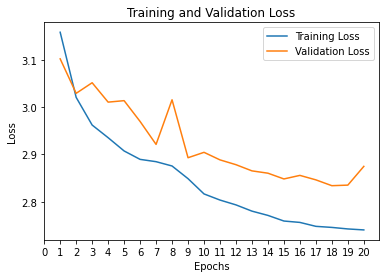

In [23]:
from numpy import arange

# Visualize the loss 
epochs = range(1, 21)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, validation_loss_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 1))
 
plt.legend(loc='best')
plt.show()

## Testing model

In [21]:
# model.load_state_dict(best_model_wts)
# _, test_accuracy, test_preds = eval_fn(test_dataloader, model)
# print(f'Model performance on test set: Accuracy = {test_accuracy}')